In [335]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot
from PIL import Image

#image = image.imread('np.jpg')
#image = Image.open('np.jpg').convert("L")
#image=np.array(image)
#print(image.dtype)
#print(image.shape)

# display the array of pixels as an image
#pyplot.imshow(image, cmap='gist_gray')
#pyplot.show()
#img = Image.open('proj1.tiff')
#imgGray = img.convert('L')
#imgGray.save('proj1.tiff')
#print(image)
#q=image.copy()

#q[q==0]=-1

## 1. Implement laser point spread function (psf) 

### Function for calculating the psf for a specific coordinate

In [180]:
def psf_xy(lam, NA, x, y, xc, yc, radius_max=np.inf):
    
    def std_dev(lam, NA):
        return 0.37*lam/NA;
    
    r = np.sqrt(np.square(x-xc)+np.square(y-yc));
    ind = r <= radius_max
    
    y = 1/np.sqrt(2*np.pi*np.square(std_dev(lam, NA))) * np.exp(-(np.square(x-xc) + np.square(y-yc)) / (2*np.square(std_dev(lam, NA))))
    
    #Clear values outside of radius_max
    y = y*ind;
    
    return y

### ... and for all points in a field of view (FOV)

In [181]:
def psf_2d_pos(FOV, lam, NA, xc, yc, clear_radius=np.inf):
    s_x, s_y = (FOV,FOV) #mat.shape
    X,Y = np.mgrid[0:s_x,0:s_y]
    mat = psf_xy(lam, NA, X, Y, xc, yc, clear_radius);
    return mat
def psf_2d(FOV, lam, NA, clear_radius=np.inf):
    s_x, s_y = (FOV,FOV) #mat.shape
    xc = s_x//2;
    yc = s_y//2;
    return psf_2d_pos(FOV, lam, NA, xc, yc, clear_radius)

### Plot psf

FWHM = 1495.30, is_confocal = True


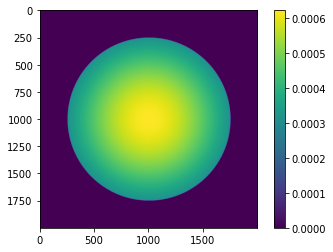

In [182]:
%matplotlib inline
lam = 1300
NA = 0.75
FWHM = 1.22/np.sqrt(2) * lam/NA
FOV = 2000
is_confocal = True
print("FWHM = %.02f, is_confocal = %s" % (FWHM, is_confocal))
L = psf_2d(FOV, lam, NA, FWHM//2 if is_confocal else np.inf)
im = plt.imshow(L)
cbar = plt.colorbar(im)

## 2. Create layout and display it

### Inverter, I=1

In [358]:
def round(i):
    return int(np.rint(i))

Technology = 45
voltage = 0.3
Kn = 1
Kp = -1.3
lam = Technology/2

Gate_N = voltage*Kn*1E7
lam3_N = voltage*Kn
lam4_N = voltage*Kn
lam6_N = voltage*Kn

Gate_P = voltage*Kp*1E7
lam3_P = voltage*Kp
lam4_P = voltage*Kp
lam6_P = voltage*Kp

##########

G1=Gate_N
G2=Gate_P
D1=lam4_N
D2=lam4_P
Gap=0;

layout = np.empty(shape=(1000,1000))
layout.fill(0)

x=round(4*lam)
y=round(4*lam)
PDN = [0,0,0,0,1] # S, Z, Y, X, W
PUN = [0,1,0,1,0] # Q, V, U, T, M


layout[0:x-1,0:y-1].fill(PDN[0]*G1) # region S

layout[0:x-1,y:y+round(2*lam)].fill(PDN[1]*G1) # Region Z

x=x+round(4*lam)
y=y+round(2*lam)
layout[0:round(4*lam)-1,y:y+round(3*lam)].fill(PDN[2]*G1) # Region y
y=y+round(3*lam)
layout[0:round(4*lam)-1,y:y+round(2*lam)].fill(PDN[3]*G1) # Region X
y=y+round(2*lam)
layout[0:round(4*lam)-1,y:y+round(4*lam)].fill(PDN[4]*G1) # Region W

x=x+round(12*lam)

layout[x:x+round(5.7777778*lam)-1,0:y-1].fill(PUN[0]*G2) # region Q

layout[x:x+round(5.7777778*lam)-1,y:y+round(2*lam)].fill(PUN[1]*G2) # Region V


y=y+round(2*lam)
layout[x:x+round(5.7777778*lam)-1,y:y+round(3*lam)].fill(PUN[2]*G2) # Region U
y=y+round(3*lam)
layout[x:x+round(5.7777778*lam)-1,y:y+round(2*lam)].fill(PUN[3]*G2) # Region T
y=y+round(2*lam)
layout[x:x+round(5.7777778*lam)-1,y:y+round(4*lam)].fill(PUN[4]*G2) # Region M


#Try to center it in a larger field of view
layout_full = np.empty(shape=(3000,3000))
layout_full.fill(0)
offset = [1250, 1450]
#offset = [0, 0]
layout_full[offset[0]:offset[0]+layout.shape[0],offset[1]:offset[1]+layout.shape[1]] = layout
#layout_full[offset[0]:offset[0]+q.shape[0],offset[1]:offset[1]+q.shape[1]] = q

M = layout_full


(3000, 3000)


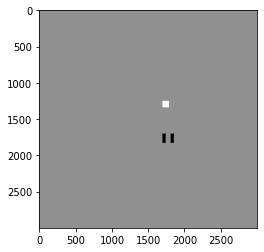

In [359]:
%matplotlib inline
im = plt.imshow(M, cmap='gist_gray')
print(M.shape)


## 3a. Calculate relative reflected light amplitude at a single point

In [360]:
def calc_and_plot_RCV(lam = 1300, NA = 0.75, is_confocal = True, offset=None):
    FWHM = 1.22/np.sqrt(2) * lam/NA
    FOV = 3000
    #print("FWHM = %.02f" % FWHM)
    if not offset:
        L = psf_2d(FOV, lam, NA, FWHM//2 if is_confocal else np.inf)
    else:
        L = psf_2d_pos(FOV, lam, NA, offset[0], offset[1], FWHM//2 if is_confocal else np.inf)
    
    amp_abs = np.sum(M * L)
    #This is only correct if the full laser spot is in L (if it is not truncated)
    #if is_confocal:
    num_pix_under_laser = np.sum(L > 0)
    amp_rel = amp_abs/num_pix_under_laser
    
    plt.imshow(L>0, cmap='gray')
    plt.imshow(M!=0, alpha=0.5, cmap='gray')
    plt.title("RCV (per nm²) = %.6f" % amp_rel)

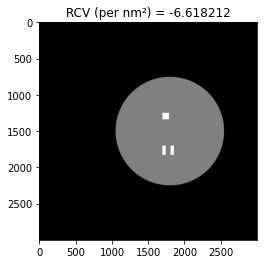

In [361]:
calc_and_plot_RCV(offset = [1500, 1800])

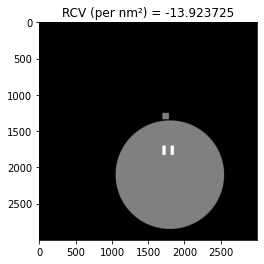

In [362]:
calc_and_plot_RCV(offset = [2100, 1800])

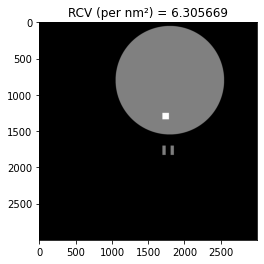

In [363]:
calc_and_plot_RCV(offset = [800, 1800])

## 3b. Convolution (EOFM)

In [364]:
from scipy.signal import fftconvolve

def calc_and_plot_EOFM(lam = 1300, NA = 0.75, is_confocal = True):
    FWHM = 1.22/np.sqrt(2) * lam/NA
    FOV = 3000
    print("FWHM = %.02f, is_confocal = %s" % (FWHM, is_confocal))
    L = psf_2d(FOV, lam, NA, FWHM//2 if is_confocal else np.inf)
    
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(11,8)
    
    R = fftconvolve(M,L,mode='same')
    ax[0].imshow(R, cmap='gist_gray')
    
    R_abs = np.abs(R)
    ax[1].imshow(R_abs, cmap='gist_gray')

FWHM = 1495.30, is_confocal = True


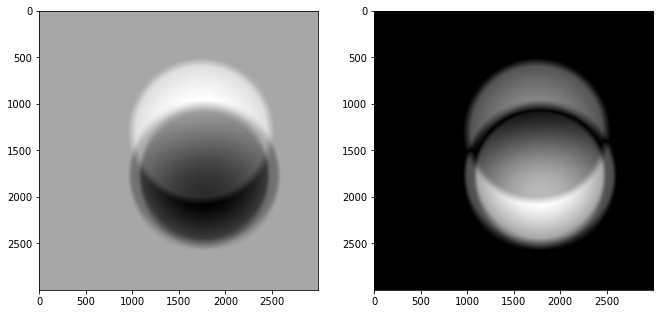

In [365]:
calc_and_plot_EOFM()

FWHM = 1495.30, is_confocal = False


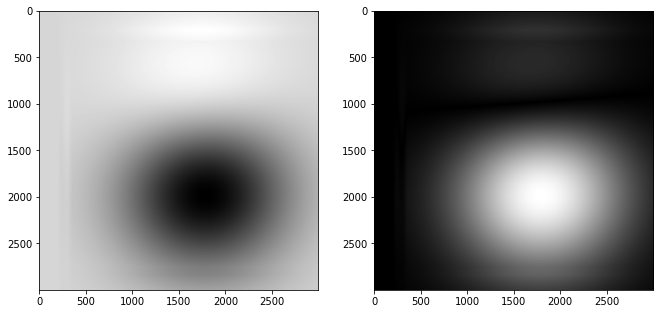

In [366]:
calc_and_plot_EOFM(is_confocal = False)

FWHM = 320.42, is_confocal = True


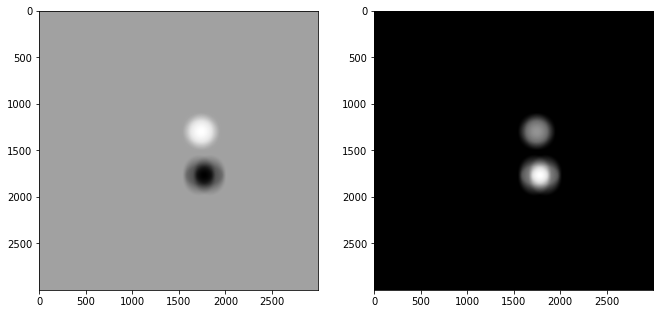

In [367]:
calc_and_plot_EOFM(lam = 1300, NA = 3.5, is_confocal = True)

FWHM = 320.42, is_confocal = False


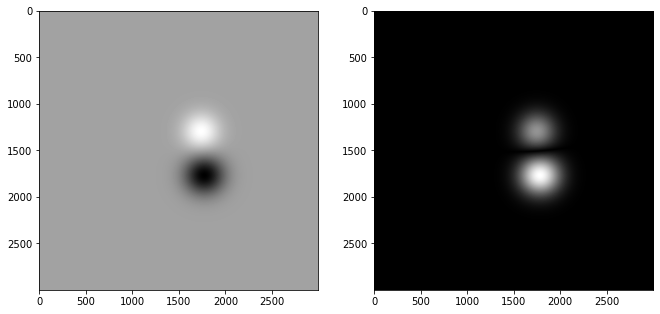

In [368]:
calc_and_plot_EOFM(lam = 1300, NA = 3.5, is_confocal = False)